In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS

In [2]:
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from ISLP.bart import BART

In [4]:
Boston = load_data("Boston")
model = MS(Boston.columns.drop('medv'), intercept = False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)

In [5]:
(X_train, X_test, y_train, y_test) = skm.train_test_split(X, Boston['medv'],
                                                         test_size=0.3,
                                                         random_state=0)

# Bagging and Random Forest

In [6]:
bag_boston = RF (max_features = X_train.shape[1], random_state= 0)
bag_boston.fit(X_train, y_train)

RandomForestRegressor(max_features=12, random_state=0)

14.634700151315787

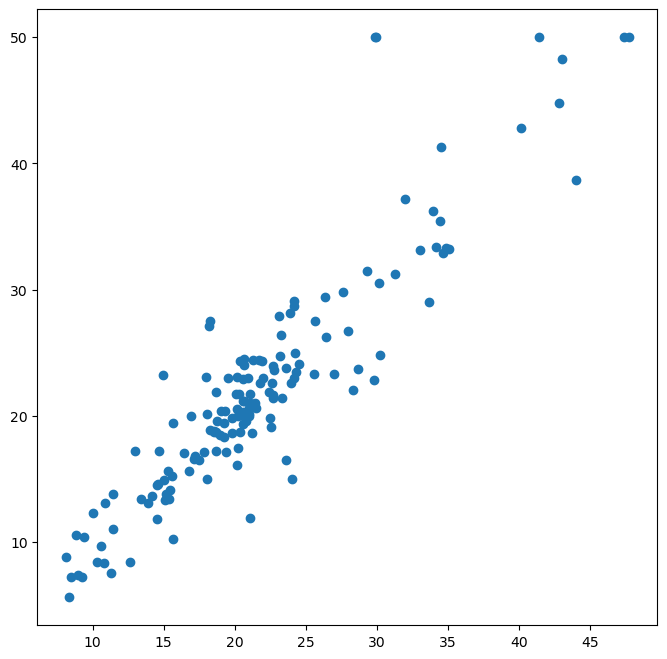

In [7]:
ax = subplots(figsize=(8,8))[1]
y_hat_bag = bag_boston.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)

In [8]:
RF_boston = RF(max_features = 6,
              random_state=0).fit(X_train, y_train)
y_hat_RF = RF_boston.predict(X_test)
np.mean((y_test - y_hat_RF)**2)

20.04276446710527

In [9]:
feature_imp = pd.DataFrame(
    {'importance':RF_boston.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by = 'importance', ascending=False)

,importance
lstat,0.356203
rm,0.332163
ptratio,0.067270
crim,0.055404
indus,0.053851
dis,0.041582
nox,0.035225
tax,0.025355
age,0.021506
rad,0.004784


# Boosting 

In [10]:
boost_boston = GBR(n_estimators = 5000,
                   learning_rate = 0.001,
                   max_depth = 3,
                   random_state = 0)
boost_boston.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.001, n_estimators=5000,
                          random_state=0)

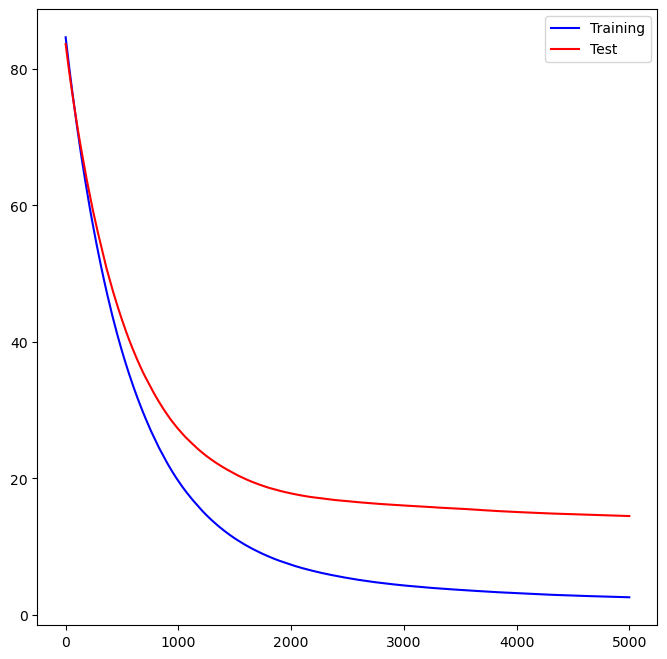

In [12]:
test_error = np.zeros_like(boost_boston.train_score_)
for idx, y_ in enumerate(boost_boston.staged_predict(X_test)):
    test_error[idx] = np.mean((y_test - y_)**2)

plot_idx = np.arange(boost_boston.train_score_.shape[0])
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx, 
        boost_boston.train_score_,
        'b',
        label = 'Training')
ax.plot(plot_idx,
       test_error,
       'r',
       label='Test')
ax.legend();

In [13]:
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)

14.481405918831591

In [16]:
boost_boston = GBR(n_estimators=5000,
                  learning_rate = 0.2,
                  max_depth = 3,
                  random_state=0)
boost_boston.fit(X_train,
                y_train)
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)

14.501514553719565

# Bayesian Additive Regressio Tree

In [18]:
bart_boston = BART(random_state=0, burnin=5, ndraw=15)
bart_boston.fit(X_train, y_train)

BART(burnin=5, ndraw=15, random_state=0)

In [19]:
yhat_test = bart_boston.predict(X_test.astype(np.float32))
np.mean((y_test - yhat_test)**2)

22.145009458109232

In [20]:
var_inclusion = pd.Series(bart_boston.variable_inclusion_.mean(0),
                          index = D.columns)
var_inclusion

crim       26.933333
zn         27.866667
indus      26.466667
chas       22.466667
nox        26.600000
rm         29.800000
age        22.733333
dis        26.466667
rad        23.666667
tax        24.133333
ptratio    24.266667
lstat      31.000000
dtype: float64